# STAT 301 Final Report

# Introduction: 


Coronary heart disease (CAD) is the leading cause of death in the United States (Menees & Bates, 2010), and the second leading cause of death in Canada (Public Health Agency of Canada, 2017). Typically, CAD is caused when plaque builds up in arteries, restricting blood flow (Menees & Bates, 2010). This causes an imbalance between the oxygen supply and demand of the heart, which often manifests as chest pain, also known as angina pectoris (Menees & Bates, 2010). While there are many precursors to CAD, including high cholesterol, tobacco use, and a family history of CAD (Menees & Bates, 2010), it is impossible to predict CAD using a single variable. For example, a resting electrocardiogram (ECG) is performed on all patients with suspected CAD, but a normal ECG does not exclude the patient from having CAD (Menees & Bates, 2010). Thus, due to the prevalence and severity of CAD, it is of keen interest to develop CAD probability models that can be universally applied to patients worldwide.

The dataset we used for our analysis is from Detrano et al. (1989), whose focus was also to generate a model to accurately predict the probability of CAD. The dataset includes clinical and test variables for 1025 patients from hospitals in Cleveland, Budapest, Zurich, Basel, and Long Beach (Detrano et al., 1989). These variables include the age of the patient (age), sex of the patient (sex), chest pain type (cp), resting blood pressure upon admission (trestbps), serum cholesterol (chol), if fasting blood sugar > 120 mg/dl (fbs), resting electrocardiographic results (restecg), maximum heart rate achieved (thalach), exercise-induced chest pain (exang), ST depression induced by exercise relative to rest (oldpeak), the slope of the peak exercise ST segment (slope), the number of major vessels coloured by fluoroscopy (ca), if the patient has thalassemia (thal), and the presence of CAD (target).

# Questions: 

Can we predict the presence of heart disease in a patient using either an easily measurable subset of variables (sex, chest pain type, age, resting blood pressure) or the full variable list by using different algorithm (forward/backward selection and LASSO). 

Which algorithm (forward/backward selection, LASSO) produces the most accurate/precise model?

## (2) Methods and Results

### a) Exploratory Data Analysis (EDA)

In [1]:
# Main developer: Michelle H. 
# Contributor: Anna M. 

library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(dplyr)
library(ggplot2)
library(cowplot)



# Loading in the dataset from Kaggle 
heart_MH <- read.csv("heart.csv")


#Checking for missing values 
sum(is.na(heart_MH))


#Number of rows (observations) within the set 
head(heart_MH)
nrow(heart_MH)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

[1] 0

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
2,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
3,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
4,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
5,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
6,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


[1] 1025

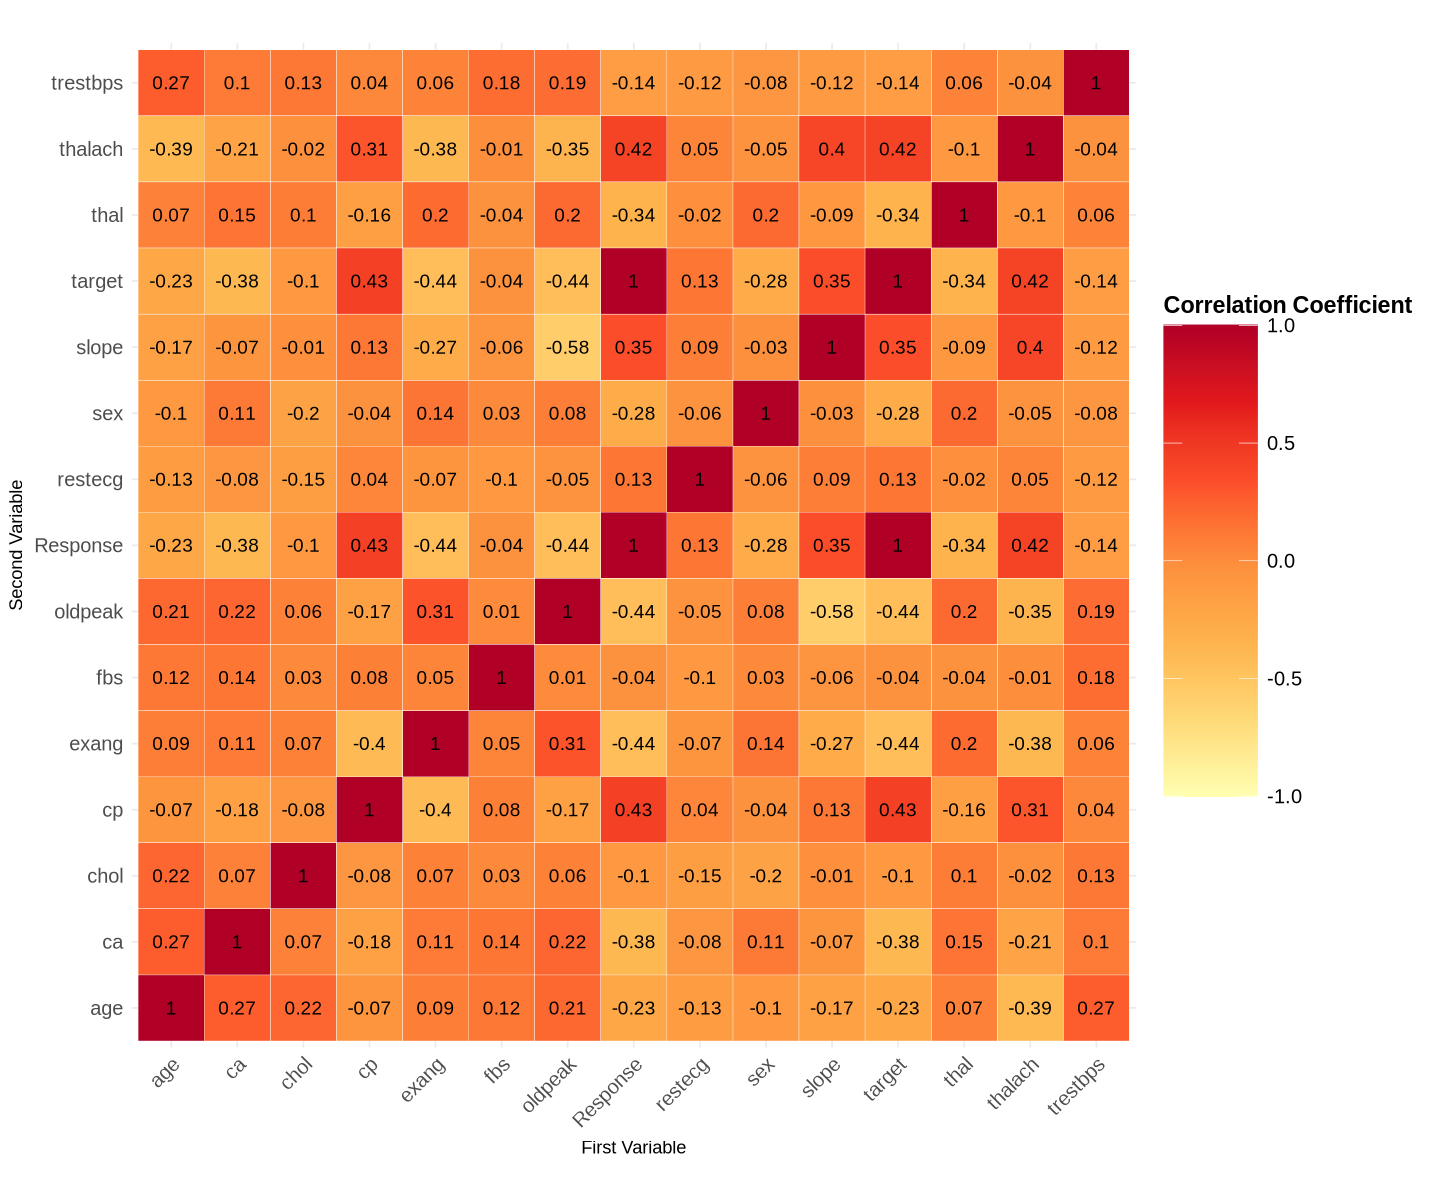

In [5]:
# Main developer: Vaibhav S.  
# Contributor: Michelle H., Anna M. 

#Correlation matrix 

corr_matrix_heart <- heart_MH %>%
  mutate(Response = as.numeric(target)) %>%
  cor() %>%
  as.data.frame() %>%
  rownames_to_column("variable1") %>%
  pivot_longer(-variable1, names_to = "variable2", values_to = "correlation")


# Plotting the correlation matrix
options(repr.plot.width = 12, repr.plot.height = 10)
plot_corr_matrix_heart <- corr_matrix_heart %>%
  ggplot(aes(x = variable1, y = variable2)) +
  geom_tile(aes(fill = correlation), color = "white") +
  scale_fill_distiller(name = "Correlation Coefficient",
                       palette = "YlOrRd",
                       direction = 1, limits = c(-1, 1)) +
  labs(x = "First Variable", y = "Second Variable") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1),
        axis.text.y = element_text(size = 12),
        legend.title = element_text(size = 14, face = "bold"),
        legend.text = element_text(size = 12),
        legend.key.size = unit(2, "cm")) +
  coord_fixed() +
  geom_text(aes(label = round(correlation, 2)), color = "black", size = 4)

# Display the correlation matrix plot
plot_corr_matrix_heart

In [6]:
# Main developer: Anna M. 
# Contributor: Michelle H. 

# Convert categorical variables

heart_MH$sex <- as.factor(heart_MH$sex)
heart_MH$cp <- as.factor(heart_MH$cp)
heart_MH$fbs <- as.factor(heart_MH$fbs)
heart_MH$restecg <- as.factor(heart_MH$restecg) 
heart_MH$exang <- as.factor(heart_MH$exang) 
heart_MH$slope <- as.factor(heart_MH$slope) 
heart_MH$ca <- as.factor(heart_MH$ca) 
heart_MH$thal <- as.factor(heart_MH$thal) 
heart_MH$target <- as.factor(heart_MH$target)

# Rename columns for easier understanding
heart_data <- heart_MH %>% 
rename(chest_pain_type = cp, cholesterol = chol, resting_bp = trestbps, fasting_blood_sugar = fbs, resting_ecg = restecg, max_heart_rate = thalach, exercise_induced_angina = exang, ST_depression = oldpeak, vessels_num = ca)



head(heart_data)

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,ST_depression,slope,vessels_num,thal,target
,<int>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
2,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
3,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
4,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
5,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
6,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


### Interpretation: 
There is no significant correlation between any of the variables. 

We will create a couple graphs to represent key relationships using selected variables in relation to the target variable. 

In [ ]:
library(ggplot2)

In [ ]:
# Main developer: Anna M. 
# Contributor: None


ggplot(heart_data, aes(x = cholesterol, fill = target)) +
geom_histogram(position = "dodge", bins = 20) +
labs(title = "Distribution of Cholesterol by Heart Disease Presence",
       x = "Serum Cholesterol", y = "Frequency")

Based on the histogram above we can imply that cholesterol level is an important indicator of heart disease

In [ ]:
# Main developer: Michelle H.  
# Contributor: None

heart_plot1 <- heart_data |>
  ggplot(aes(x = age, 
             y = max_heart_rate, 
             color = target)) +
  labs(x = "Age (in years)", y = "Maximum Heart Rate Achieved (beats per minute)") +
  theme(legend.position = "none") +
  geom_point() +
  ggtitle("Age and Thalach") 

heart_plot1

This scatterplot explores the relationship between age and maximum heart rate achieved. There is no clear relationship. 

In [ ]:
# Main developer: Vaibhav S.
# Contributor: None

# Resting Blood Pressure by Heart Disease Status
ggplot(heart_data, aes(x = factor(target), y = resting_bp, fill = factor(target))) +
  geom_boxplot(alpha = 0.7) +
  scale_fill_manual(values = c("0" = "blue", "1" = "red"), labels = c("No Disease", "Disease")) +
  labs(title = "Resting Blood Pressure by Heart Disease Status", x = "Heart Disease Status", y = "Resting Blood Pressure (mm Hg)", fill = "Heart Disease") +
  scale_x_discrete(labels = c("0" = "No Disease", "1" = "Disease"))

This boxplot visualizes the resting blood pressure (`trestbps`) distribution for patients with and without heart disease.

In [ ]:
# Main developer: Paul E. 
# Contributor: None

ecg_plot <- ggplot(heart_data, aes(x = resting_ecg)) +
    geom_bar(aes(fill = target), color = "white") +
    labs(x = "ECG result",
         title = "Bar plot of ECG Results (All Patients)") +
    scale_fill_discrete(name = "Heart Disease Diagnosis")
         
ecg_plot

This bar plot visualizes `ECG` to `target`. 

For all the plots, we colored relative to `target`. 

In [ ]:
# Main developer: Anna M. 
# Contributor: None

#0 = female; 1 = male 

ggplot(heart_data, aes(x = sex)) +
    geom_bar(aes(fill = target), color = "white") +
    labs(x = "Sex",
         title = "Bar plot Sex (All Patients)") +
    scale_fill_discrete(name = "Heart Disease Diagnosis")

Based on this bar plot we can see that the dataset is imbalanced, there are more males than females. Even if `sex` is a strong predictor, the imbalance may lead to misleading importance scores for this feature because the dataset is not representative of the population.

### b) Methods: Plan

### Methods
To start, the dataset was split into a selection and training dataset, with a 30/70 split. We used forward selection, backward selection and LASSO regression to build the most accurate models possible.

### Forward and Backward Selection 

For forward and backward selection, the ```regsubsets``` function was used to understand which variables would be included for a model of a given size. The model with the highest **adjusted R^2** was selected and a ```glm``` model was fit using the variables included. 




### Lasso 

Lasso regularization that performs feature selection and coefficient estimation by penalizing large coefficients. This approach enables the model to focus on the most predictive features.

First cross-validation was performed on the model matrix to obtain the optimal parameter for lambda. The chosen lambda value was the one which provided the largest AUC score. Then using glmnet the logistic regression model was fitted by specifying family = "binomial" and, while applying asso regularization by specifying alpha = 1.

The AUC for the model is 0.948


### Subset

We selected a couple easily measurable variables and created a `glm` model using those variables to predict `target`. 

Confusion matrix and AUC plots were created for all types of models used. 


In [ ]:
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(faraway)
library(broom)
library(leaps)
library(mltools)
library(tidyverse)
library(caret)
library(pROC)
library(boot)
library(glmnet)

In [ ]:
set.seed(584)

# Main developer: Paul E. 
# Contributor: None

# splitting data into testing and training set
heart_data <- heart_data %>%
    mutate(ID = row_number())

training_data <- 
    heart_data %>%
    slice_sample(prop = 0.70, replace = FALSE)

selection_data <- 
    heart_data %>%
    anti_join(training_data, by = "ID")

training_data <- 
    training_data %>% 
    select(-"ID")

selection_data <- 
    selection_data %>% 
    select(-"ID")

head(training_data)
nrow(training_data)

head(selection_data)
nrow(selection_data)

In [ ]:
# Main developer: Paul E. 
# Contributor: None

# using backwards selection
backward_sel <- 
    regsubsets(
        x = target ~ ., 
        nvmax = 22,
        data = selection_data,
        method = "backward",
    )

backward_sel_summary <- summary(backward_sel)

backward_sel_summary_df <- tibble(
    n_input_variables = 1:22,
    RSQ = backward_sel_summary$rsq,
    RSS = backward_sel_summary$rss,
    ADJ.R2 = backward_sel_summary$adjr2
)

backward_sel_summary
backward_sel_summary_df

In [ ]:
# Main developer: Paul E. 
# Contributor: None
heart_data$target <- as.factor(heart_data$target)
heart_data
# building model based on results of backward selection
backward_sel_model <- glm(target ~ sex + chest_pain_type + resting_bp + cholesterol + resting_ecg + max_heart_rate + ST_depression + slope + vessels_num + thal, 
                           data = training_data, 
                           family = "binomial")

In [ ]:
# Main developer: Paul E. 
# Contributor: None

# building the confusion matrix
backward_pred_class <- 
  round(predict(backward_sel_model, type = "response"), 0)

backward_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(backward_pred_class),
    reference = as.factor(training_data$target),
    positive = '1'
)

In [ ]:
# Main developer: Paul E. 
# Contributor: Michelle H. 

#same thing, this time for forward selection
forward_sel <- 
    regsubsets(
        x = target ~ ., 
        nvmax = 22,
        data = selection_data,
        method = "forward",
    )

forward_sel_summary <- summary(forward_sel)

forward_sel_summary_df <- tibble(
    n_input_variables = 1:22,
    RSQ = forward_sel_summary$rsq,
    RSS = forward_sel_summary$rss,
    ADJ.R2 = forward_sel_summary$adjr2
)

forward_sel_summary
forward_sel_summary_df

forward_sel_model <- glm(target ~ age + sex + chest_pain_type + resting_bp + resting_ecg + max_heart_rate + exercise_induced_angina + ST_depression + slope + vessels_num + thal, 
                           data = training_data, 
                           family = "binomial")

forward_pred_class <- 
  round(predict(forward_sel_model, type = "response"), 0)

forward_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(forward_pred_class),
    reference = as.factor(training_data$target),
    positive = '1'
)

In [ ]:
# Main developer: Paul E. 
# Contributor: None

#comparing confusion matrices
backward_confusion_matrix
forward_confusion_matrix

#we can see that despite the minor differences in model selection, there is little difference in prediction performance

In [ ]:
# Main developer: Paul E. 
# Contributor: None

# ROC curve for backward selection model
ROC_backward <- 
    roc(response = training_data$target, 
        predictor = predict(backward_sel_model, type = "response"))

plot(ROC_backward,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Heart Disease Dataset (Backward Selection)")


ROC_foreward <- 
    roc(response = training_data$target, 
        predictor = predict(foreward_sel_model, type = "response"))

plot(ROC_foreward,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Curves for Heart Disease Dataset (Forward Selection)")

### Lasso Regression

In [ ]:
# Main developer: Anna M. 
# Contributor: None

set.seed(584)

heart_data <- heart_data %>% mutate(ID = row_number())

heart_train <- 
    heart_data %>% 
    slice_sample(prop = 0.70)

heart_test <- 
    heart_data %>% 
    anti_join(heart_train, by = "ID")

heart_train <- heart_train  %>% select(-ID)
heart_test <- heart_test  %>% select(-ID)

head(heart_train)
nrow(heart_train)
nrow(heart_test)

In [ ]:
# Main developer: Anna M. 
# Contributor: None

# Use cross-validation to select the optimal regularization parameter (λ)

model_matrix_X_train <- 
    model.matrix(object = target ~ .,
                 data = heart_train)[, -1]

matrix_Y_train <- 
    as.matrix(heart_train$target, ncol = 1)

Now we need to find the value of $\lambda$ that provides the largest average AUC.

In [ ]:
# Main developer: Anna M. 
# Contributor: None

heart_cv_lambda_LASSO <- cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = "binomial",
  type.measure = "auc",
  nfolds = 5
)

heart_cv_lambda_LASSO

In [ ]:
# Main developer: Anna M. 
# Contributor: None

plot(heart_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

In [ ]:
# Main developer: Anna M. 
# Contributor: None

# Lambda min gives the best predictive performance
heart_cv_lambda_LASSO$cvm[heart_cv_lambda_LASSO$index["min",]]
heart_cv_lambda_LASSO$cvm[heart_cv_lambda_LASSO$index["1se",]]

In [ ]:
# Main developer: Anna M. 
# Contributor: None


# Choose lambda min
heart_lambda_AUC_LASSO <- round(heart_cv_lambda_LASSO$lambda.min, 5)
heart_lambda_AUC_LASSO

In [ ]:
# Main developer: Anna M. 
# Contributor: None

heart_LASSO_AUC <- 
    glmnet(
        x = model_matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = heart_lambda_AUC_LASSO)

In [ ]:
# Main developer: Anna M. 
# Contributor: None

coef(heart_LASSO_AUC)

In [ ]:
# Main developer: Anna M. 
# Contributor: None

model_matrix_X_test <- 
    model.matrix(object = target ~ .,
                 data = heart_test)[, -1]

predicted_probabilities <- predict(heart_LASSO_AUC, 
                                   newx = model_matrix_X_test, 
                                   type = "response")

# ROC
ROC_lasso <- roc(
  response = heart_test$target,
  predictor = predicted_probabilities[,"s0"]
)

predicted_labels <- ifelse(predicted_probabilities[,"s0"] > 0.5, 1, 0)

confusion_matrix <- confusionMatrix(factor(predicted_labels), factor(heart_test$target))

accuracy <- confusion_matrix$overall["Accuracy"]
precision <- confusion_matrix$byClass["Precision"]
recall <- confusion_matrix$byClass["Recall"]

auc_value <- auc(ROC_lasso)
cat("AUC: ", auc_value, "\n")
accuracy
precision
recall

In [ ]:
# Main developer: Anna M. 
# Contributor: None

plot(ROC_lasso,
  print.auc = TRUE, col = "blue", lwd = 3, lty = 2,
  main = "ROC Lasso Curve for Heart Dataset"
)

In [ ]:
# Main developer: Anna M. 
# Contributor: None

# Checking if there is imbalance in the dataset
table(heart_data$target)

### Subset of variables

In [ ]:
# Main developer: Vaibhav S.
# Contributor: None

set.seed(584)

train_index <- createDataPartition(heart_data$target, p = 0.8, list = FALSE)
train_data <- heart_data[train_index, ]
test_data <- heart_data[-train_index, ]

# Fit logistic regression model
log_model <- glm(target ~ age + resting_bp + sex + resting_ecg + chest_pain_type, 
                 data = train_data, 
                 family = binomial)

# Summary of the model
model_summary <- summary(log_model)
print(model_summary)

In [ ]:
# Main developer: Vaibhav S.
# Contributor: None


# Calculate odds ratios and confidence intervals
exp_coef <- exp(coef(log_model))  # Odds ratios
conf_int <- exp(confint(log_model))  # Confidence intervals
results_table <- cbind(Odds_Ratio = exp_coef, conf_int)

# Print the results table
print(results_table)

In [ ]:
# Main developer: Vaibhav S.
# Contributor: None

# Predict on the test set and calculate accuracy
library(pROC)
test_data$predicted <- ifelse(predict(log_model, newdata = test_data, type = "response") > 0.5, 1, 0)
conf_matrix <- table(test_data$target, test_data$predicted)
accuracy <- sum(diag(conf_matrix)) / sum(conf_matrix)
roc_curve <- roc(test_data$target, predict(log_model, newdata = test_data, type = "response"))
cat("Model Accuracy: ", accuracy, "\n")

In [ ]:
# Main developer: Vaibhav S.
# Contributor: None

auc_value <- auc(roc_curve)
cat("AUC: ", auc_value, "\n")

In [ ]:
# Main developer: Vaibhav S.
# Contributor: Michelle H. 

# Ensure target variable is a factor with correct levels
test_data$target <- factor(test_data$target, levels = c(0, 1))
plot(roc_curve, main = "ROC Curve for Logistic Regression Model", col = "blue", lwd = 2)

In [ ]:
# Main developer: Anna M. 
# Contributor: Michelle H. 

model_names <- c("Backwards selection and Logistic", "Lasso Regression", "Forward Selection and Logistic", "Logistic for Subset")
prediction_accuracy <- c(0.8661, 0.8864, 0.8884, 0.7794)
AUC <- c(0.942, 0.9477, 0.944, 0.8571)
tibble(model_names, prediction_accuracy, AUC)

# Discussion

# References 

Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J.-J., Sandhu, S., Guppy, K. H., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. The American Journal of Cardiology, 64(5), 304–310. https://doi.org/10.1016/0002-9149(89)90524-9

Menees, D. S., & Bates, E. R. (2010). Evaluation of patients with suspected coronary artery disease. Coronary Artery Disease, 21(7), 386. https://doi.org/10.1097/MCA.0b013e32833bfdf7

Public Health Agency of Canada. (2017, February 10). Heart Disease in Canada [Education and awareness]. https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html
